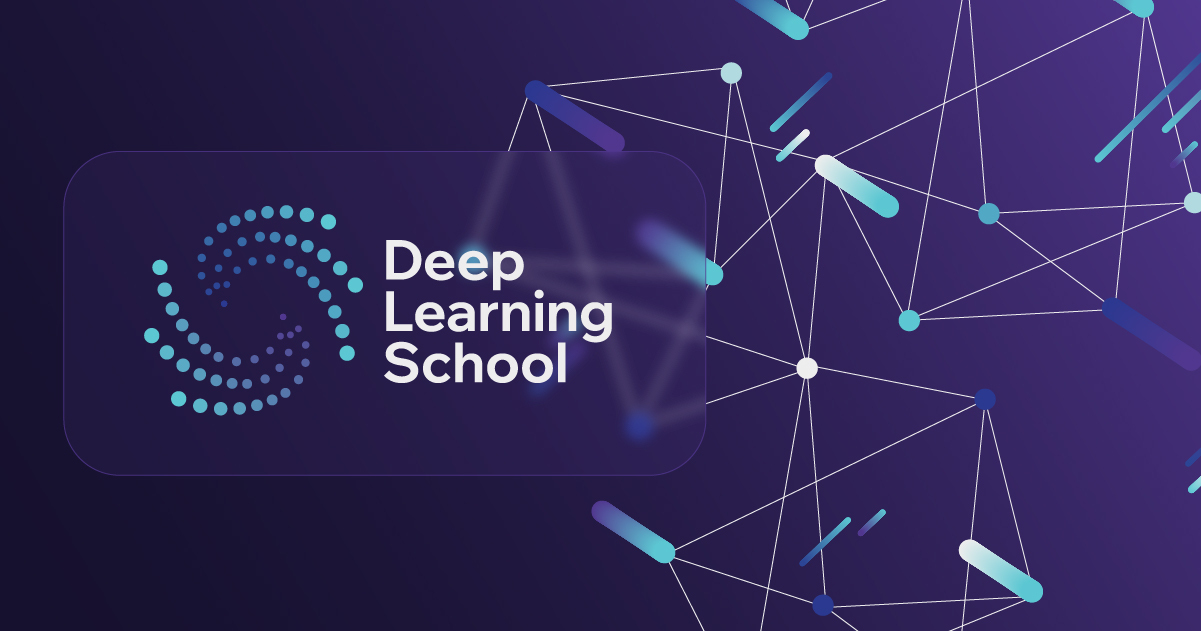

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h1>



В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import random

sns.set(style="darkgrid", font_scale=1.4)

In [2]:
# Reduce stochasticity

SEED = 42

# PyTorch
torch.manual_seed(SEED)

# CUDA (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups

# NumPy
np.random.seed(SEED)

# Python's built-in random
random.seed(SEED)

In [3]:
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [125]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

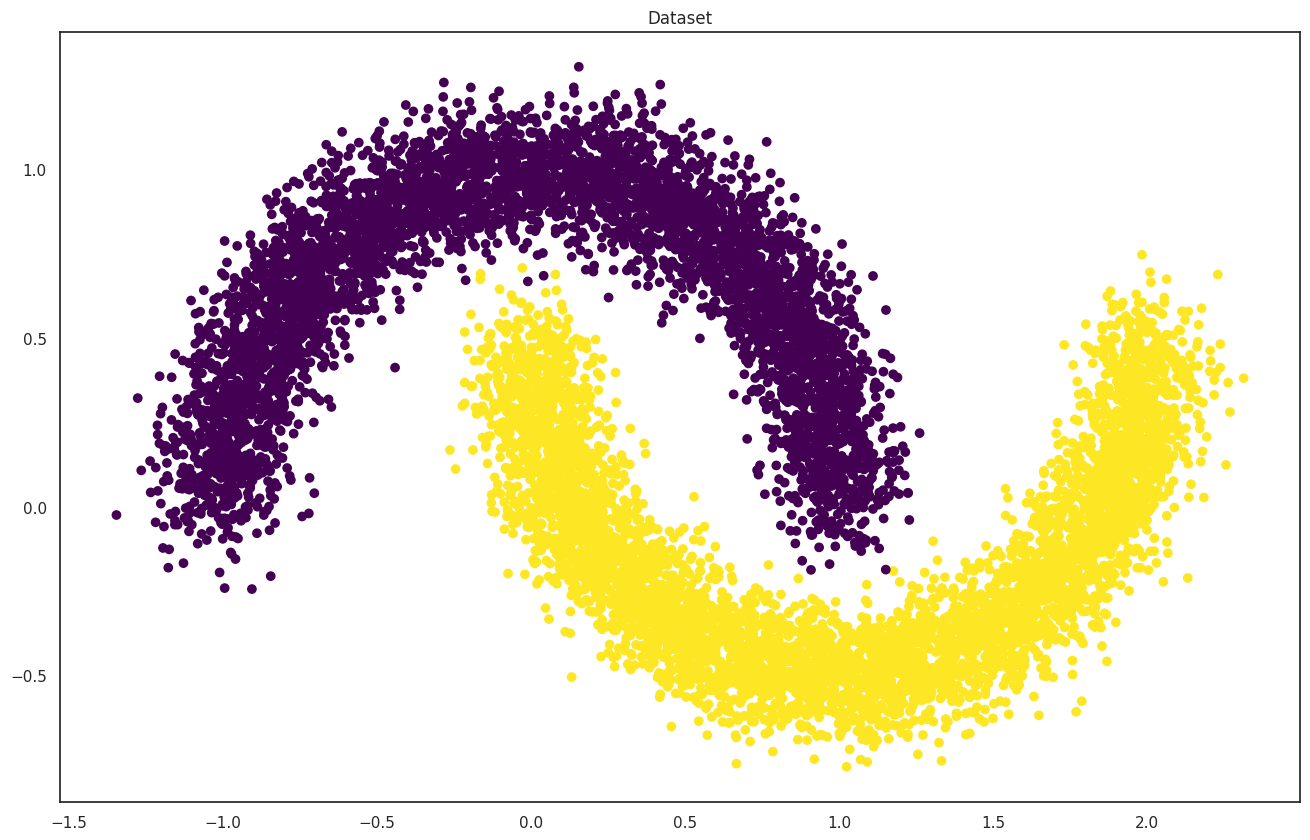

In [126]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [10]:
X_train_t =  torch.tensor(X_train)
y_train_t =  torch.tensor(y_train)
X_val_t =  torch.tensor(X_val)
y_val_t =  torch.tensor(y_val)

Создаем `Dataset` и `DataLoader`.

In [11]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к классу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидой. Чаще всего в качестве сигмоида берут:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [48]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  torch.matmul(x, self.weights)
        if self.bias:
            x +=  self.bias_term
        return x

In [49]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [64]:
for par in linear_regression.parameters():
  print(par)

Parameter containing:
tensor([[ 0.9157],
        [-0.4198]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-1.1929], device='cuda:0', requires_grad=True)


**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

**Ответ:**

In [52]:
!pip install torchinfo

In [65]:
torch.use_deterministic_algorithms(False)
from torchinfo import summary
summary(linear_regression.cuda(), (10,2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [10, 1]                   3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Train loop

Перейдём непосредственно к обучению.

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обнуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [103]:
for x, y in train_dataloader:
  print(y.view(len(y.numpy()), -1))
  break

tensor([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],

### Задание. Реализация цикла обучения

In [104]:
from tqdm import tqdm
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
linear_regression.to('cuda')
for epoch in tqdm(range(max_epochs)):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch.type(torch.float32).to('cuda'))
        loss =  loss_function(outp, y_batch.view(-1, 1).type(torch.float32).to('cuda'))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch.to('cuda')).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration: 0
Batch accuracy: 0.78125


  3%|▎         | 3/100 [00:00<00:18,  5.18it/s]

Iteration: 100
Batch accuracy: 0.8125


  4%|▍         | 4/100 [00:00<00:17,  5.62it/s]

Iteration: 200
Batch accuracy: 0.8125


  5%|▌         | 5/100 [00:01<00:20,  4.62it/s]

Iteration: 300
Batch accuracy: 0.890625


  7%|▋         | 7/100 [00:01<00:23,  4.00it/s]

Iteration: 400
Batch accuracy: 0.8671875


  9%|▉         | 9/100 [00:02<00:26,  3.46it/s]

Iteration: 500
Batch accuracy: 0.90625


  9%|▉         | 9/100 [00:02<00:26,  3.44it/s]


Iteration: 582.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:**

### Визуализируем результаты

[tensor(0.4068), tensor(0.3532), tensor(0.4403), tensor(0.4257), tensor(0.3774), tensor(0.3528), tensor(0.3817), tensor(0.4176), tensor(0.3985), tensor(0.4121), tensor(0.3559), tensor(0.3922), tensor(0.3640), tensor(0.4001), tensor(0.3996), tensor(0.4199), tensor(0.4233), tensor(0.3977), tensor(0.4044), tensor(0.3427), tensor(0.3493), tensor(0.4075), tensor(0.3640), tensor(0.3726), tensor(0.3976), tensor(0.3999), tensor(0.3547), tensor(0.3761), tensor(0.3063), tensor(0.3610), tensor(0.3974), tensor(0.3857), tensor(0.3260), tensor(0.4212), tensor(0.3589), tensor(0.3424), tensor(0.4377), tensor(0.4075), tensor(0.3841), tensor(0.3837), tensor(0.3617), tensor(0.3826), tensor(0.4019), tensor(0.3350), tensor(0.4311), tensor(0.3884), tensor(0.3567), tensor(0.4357), tensor(0.3821), tensor(0.4120), tensor(0.4185), tensor(0.4191), tensor(0.3456), tensor(0.3493), tensor(0.4137), tensor(0.3474), tensor(0.3827), tensor(0.3668), tensor(0.4039), tensor(0.3900), tensor(0.3369), tensor(0.4265), tensor(

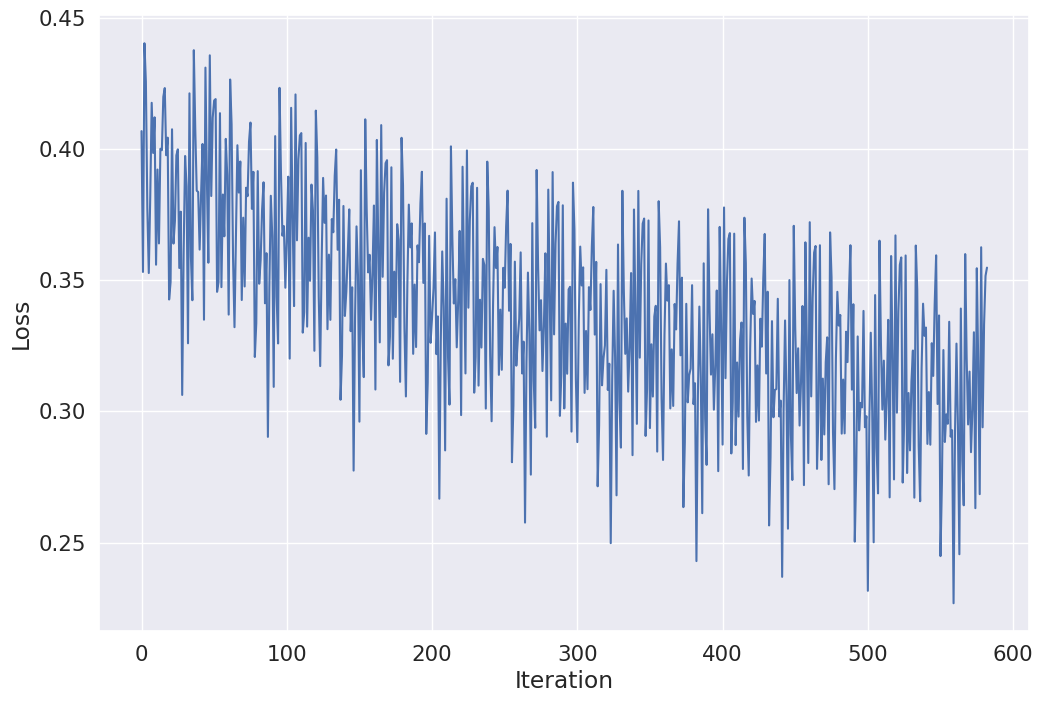

In [111]:
plt.figure(figsize=(12, 8))
losses_cpu = [x.cpu() for x in losses]
print(losses_cpu)
plt.plot(range(len(losses_cpu)), losses_cpu)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

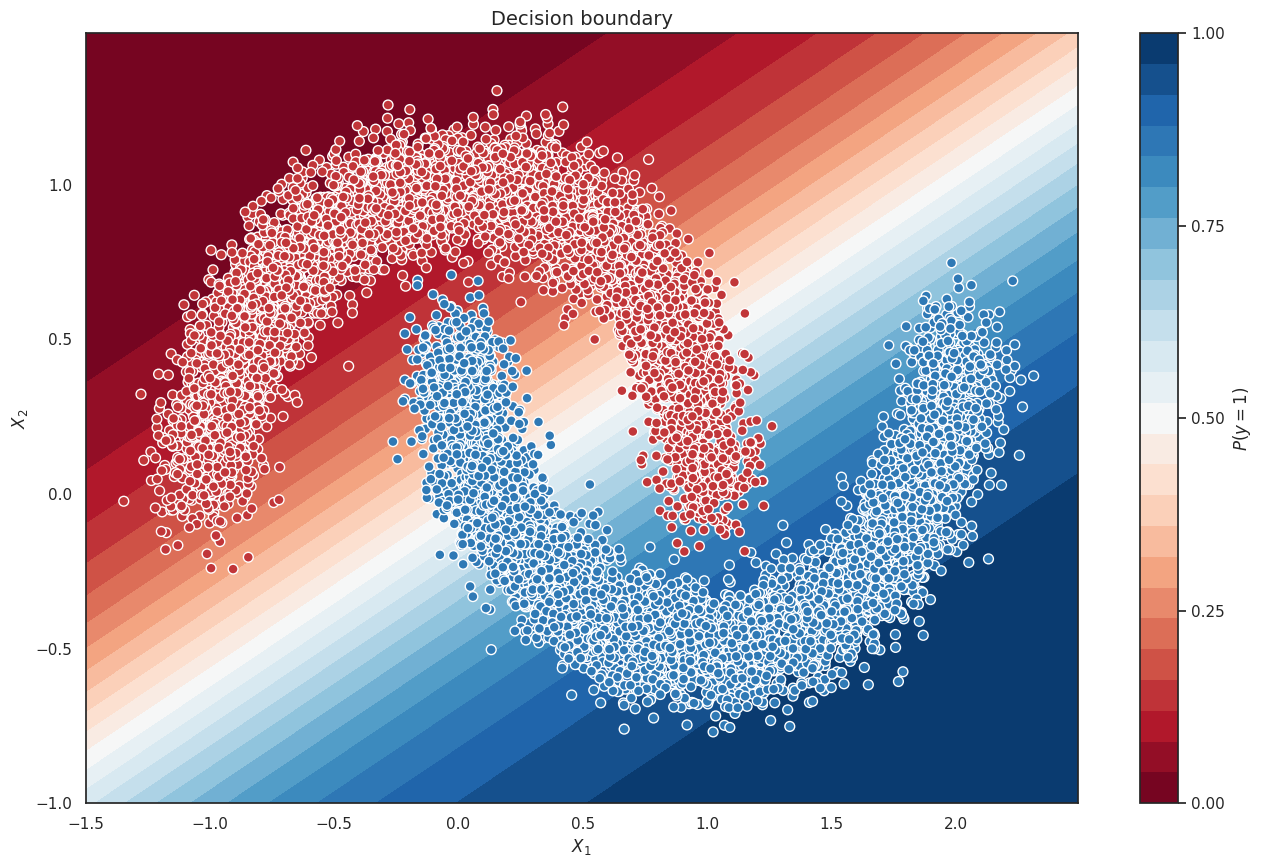

In [127]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32).to('cuda')
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.cpu().numpy()


f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)

ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [148]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probs = torch.sigmoid(model(x_batch.type(torch.float32).to('cuda')))
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.cpu().numpy().flatten()))
    return predictions.flatten()


preds = predict(train_dataloader, linear_regression)
print(preds[:5])
print(len(preds) == len(X_train_t))

[1. 0. 0. 0. 0.]
True


In [154]:
from sklearn.metrics import accuracy_score

val_preds = predict(val_dataloader, linear_regression)
print(f'Accuracy = {(val_preds == y_val).sum()/y_val.shape[0] * 100}')

Accuracy = 85.68


**Вопрос 3**

Какое `accuracy` получается после обучения? (ваш ответ может варьироваться в зависимости от запуска)

**Ответ:** 85.68

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [155]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size = 128)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.21MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.84MB/s]


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.


In [156]:
28*28

784

In [207]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128, 128),
    nn.ELU(),
    nn.Linear(128,10)
)

Задайте лосс для обучения (кросс-энтропия).

Вспомним, что такое кросс-энтропийная функция потерь:

$$
L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{i=1}^{C} y_{ni} \log(\hat{y}_{ni})
$$

где:
- $N$ — количество объектов в выборке,
- $C$ — количество классов,
- $y_{ni}$ — истинная метка (one-hot представление),
- $\hat{y}_{ni}$ — предсказанная вероятность модели для класса $i$ на примере $n$.

***Пример расчета***

Рассмотрим пример расчета кросс-энтропийной функции потерь для задачи многоклассовой классификации с 10 классами. Предположим, что у нас есть один объект, истинный класс которого известен, а модель выдала свои предсказания в виде вероятностей для каждого класса.

Пусть объект является цифрой 2. Тогда:
     $$
     y = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
     $$

Пусть модель выдала следующие вероятности для 10 классов:  
     $$
     \hat{y} = [0.1, 0.05, 0.6, 0.15, 0.05, 0.02, 0.01, 0.01, 0.01, 0.0]
     $$

$$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$



Только один элемент $y_i$ равен 1, остальные равны 0. Поэтому:

$
L = -\sum_{i=1}^{C} y_i \log(\hat{y}_i) = - y_2 \cdot log(\hat{y}_2) = - 1 \cdot log(0.6) \approx 0.51
$

In [208]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [195]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [209]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [210]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    print(f'--------epoch #{epoch}--------')
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        print(f"dataloader: {k}")
        for x_batch, y_batch in tqdm(dataloader):
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch.to(device))
              # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch.to(device))
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs

            preds = outp.argmax(-1)
            correct = (preds.cpu() == y_batch).numpy().sum()
            all =  y_batch.numpy().shape[0]
            epoch_correct += correct#.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


--------epoch #0--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 36.93it/s]


Epoch: 1
Loader: train. Accuracy: 0.8783333333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 41.75it/s]


Loader: valid. Accuracy: 0.9276
--------epoch #1--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.03it/s]


Epoch: 2
Loader: train. Accuracy: 0.9422666666666667
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 31.55it/s]


Loader: valid. Accuracy: 0.9438
--------epoch #2--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.43it/s]


Epoch: 3
Loader: train. Accuracy: 0.9582333333333334
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 41.68it/s]


Loader: valid. Accuracy: 0.9606
--------epoch #3--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.36it/s]


Epoch: 4
Loader: train. Accuracy: 0.96795
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.30it/s]


Loader: valid. Accuracy: 0.9659
--------epoch #4--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.90it/s]


Epoch: 5
Loader: train. Accuracy: 0.9733666666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.93it/s]


Loader: valid. Accuracy: 0.9688
--------epoch #5--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.12it/s]


Epoch: 6
Loader: train. Accuracy: 0.9762
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.43it/s]


Loader: valid. Accuracy: 0.9697
--------epoch #6--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.91it/s]


Epoch: 7
Loader: train. Accuracy: 0.9789833333333333
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 33.57it/s]


Loader: valid. Accuracy: 0.9673
--------epoch #7--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.76it/s]


Epoch: 8
Loader: train. Accuracy: 0.9818833333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.54it/s]


Loader: valid. Accuracy: 0.9643
--------epoch #8--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.26it/s]


Epoch: 9
Loader: train. Accuracy: 0.9844
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.23it/s]


Loader: valid. Accuracy: 0.9678
--------epoch #9--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.66it/s]


Epoch: 10
Loader: train. Accuracy: 0.9850333333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.24it/s]

Loader: valid. Accuracy: 0.9699


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

Функции активации добавляют ***нелинейность в модель***, что позволяет сети решать сложные задачи, такие как классификация и регрессия. Без функций активации нейронная сеть была бы линейной моделью, так как ***композиция линейных преобразований*** это ***линейное преобразование***.

**ReLU (Rectified Linear Unit)**
   - Формула: $ f(x) = \max(0, x) $
   - Диапазон значений: $ [0, \infty) $

**Leaky ReLU**
   - Формула: $ f(x) = \max(\alpha x, x) $, где $ \alpha $ — маленькое положительное число (обычно $ \alpha = 0.01 $).
   - Диапазон значений: $ (-\infty, \infty) $

**Exponential Linear Unit (ELU)**
   - Формула:
   $f(x) = $
     \begin{cases}
     x & \text{если } x > 0 \\
     \alpha (e^x - 1) & \text{если } x \leq 0
     \end{cases}
   - Диапазон значений:  $ (-\alpha, \infty) $

**Линейная функция активации**
   - Формула: $ f(x) = x $
   - Диапазон значений: $ (-\infty, \infty) $

   Обратите внимание, что данная функция активации **не добавляет** нелинейности.

In [224]:
elu_accuracy = accuracy["valid"]

In [217]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def train_model(model, dataloaders):
  max_epochs = 10
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())
  accuracy = {"train": [], "valid": []}
  for epoch in range(max_epochs):
    print(f'--------epoch #{epoch+1}--------')
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        print(f"dataloader: {k}")
        for x_batch, y_batch in tqdm(dataloader):
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch.to(device))
              # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch.to(device))
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs

            preds = outp.argmax(-1)
            correct = (preds.cpu() == y_batch).numpy().sum()
            all =  y_batch.numpy().shape[0]
            epoch_correct += correct#.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
  return accuracy


def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128,10)
    )
    model.to(device)
    accuracies = train_model(model, loaders)

    return accuracies

test_activation_function(nn.ELU())

--------epoch #1--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 36.99it/s]


Loader: train. Accuracy: 0.8795833333333334
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.49it/s]


Loader: valid. Accuracy: 0.9141
--------epoch #2--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 36.75it/s]


Loader: train. Accuracy: 0.9430333333333333
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 37.69it/s]


Loader: valid. Accuracy: 0.9479
--------epoch #3--------
dataloader: train


100%|██████████| 469/469 [00:14<00:00, 33.29it/s]


Loader: train. Accuracy: 0.9589
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.67it/s]


Loader: valid. Accuracy: 0.9594
--------epoch #4--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.29it/s]


Loader: train. Accuracy: 0.9681166666666666
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 44.35it/s]


Loader: valid. Accuracy: 0.9664
--------epoch #5--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.24it/s]


Loader: train. Accuracy: 0.9735166666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.51it/s]


Loader: valid. Accuracy: 0.9709
--------epoch #6--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.24it/s]


Loader: train. Accuracy: 0.9773333333333334
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.74it/s]


Loader: valid. Accuracy: 0.9682
--------epoch #7--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.07it/s]


Loader: train. Accuracy: 0.9795
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 39.25it/s]


Loader: valid. Accuracy: 0.9696
--------epoch #8--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.73it/s]


Loader: train. Accuracy: 0.9832333333333333
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 36.06it/s]


Loader: valid. Accuracy: 0.9692
--------epoch #9--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.83it/s]


Loader: train. Accuracy: 0.9838333333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.65it/s]


Loader: valid. Accuracy: 0.965
--------epoch #10--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.86it/s]


Loader: train. Accuracy: 0.9851166666666666
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 44.05it/s]


Loader: valid. Accuracy: 0.9622


{'train': [np.float64(0.8795833333333334),
  np.float64(0.9430333333333333),
  np.float64(0.9589),
  np.float64(0.9681166666666666),
  np.float64(0.9735166666666667),
  np.float64(0.9773333333333334),
  np.float64(0.9795),
  np.float64(0.9832333333333333),
  np.float64(0.9838333333333333),
  np.float64(0.9851166666666666)],
 'valid': [np.float64(0.9141),
  np.float64(0.9479),
  np.float64(0.9594),
  np.float64(0.9664),
  np.float64(0.9709),
  np.float64(0.9682),
  np.float64(0.9696),
  np.float64(0.9692),
  np.float64(0.965),
  np.float64(0.9622)]}

In [218]:
plain_accuracy = test_activation_function(nn.Identity()) #There is no non-linearity

--------epoch #1--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.83it/s]


Loader: train. Accuracy: 0.8579
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.76it/s]


Loader: valid. Accuracy: 0.868
--------epoch #2--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.32it/s]


Loader: train. Accuracy: 0.8898
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 44.78it/s]


Loader: valid. Accuracy: 0.8899
--------epoch #3--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.64it/s]


Loader: train. Accuracy: 0.8953333333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.63it/s]


Loader: valid. Accuracy: 0.8946
--------epoch #4--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.30it/s]


Loader: train. Accuracy: 0.8988166666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.40it/s]


Loader: valid. Accuracy: 0.8962
--------epoch #5--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.92it/s]


Loader: train. Accuracy: 0.9004833333333333
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 36.29it/s]


Loader: valid. Accuracy: 0.8965
--------epoch #6--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.39it/s]


Loader: train. Accuracy: 0.9021333333333333
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 37.36it/s]


Loader: valid. Accuracy: 0.8968
--------epoch #7--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.29it/s]


Loader: train. Accuracy: 0.90375
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.40it/s]


Loader: valid. Accuracy: 0.8972
--------epoch #8--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.51it/s]


Loader: train. Accuracy: 0.9051166666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.09it/s]


Loader: valid. Accuracy: 0.897
--------epoch #9--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.12it/s]


Loader: train. Accuracy: 0.90605
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.82it/s]


Loader: valid. Accuracy: 0.8967
--------epoch #10--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.58it/s]


Loader: train. Accuracy: 0.9074
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.39it/s]

Loader: valid. Accuracy: 0.8974


In [219]:
relu_accuracy = test_activation_function(nn.ReLU())

--------epoch #1--------
dataloader: train


100%|██████████| 469/469 [00:13<00:00, 34.82it/s]


Loader: train. Accuracy: 0.8604333333333334
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 39.44it/s]


Loader: valid. Accuracy: 0.9109
--------epoch #2--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.13it/s]


Loader: train. Accuracy: 0.9352833333333334
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.13it/s]


Loader: valid. Accuracy: 0.9438
--------epoch #3--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.84it/s]


Loader: train. Accuracy: 0.95305
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 41.49it/s]


Loader: valid. Accuracy: 0.9554
--------epoch #4--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.97it/s]


Loader: train. Accuracy: 0.9628333333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.26it/s]


Loader: valid. Accuracy: 0.9584
--------epoch #5--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.99it/s]


Loader: train. Accuracy: 0.9692
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 36.76it/s]


Loader: valid. Accuracy: 0.9638
--------epoch #6--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.88it/s]


Loader: train. Accuracy: 0.9730333333333333
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 35.79it/s]


Loader: valid. Accuracy: 0.9672
--------epoch #7--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.76it/s]


Loader: train. Accuracy: 0.9760833333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.19it/s]


Loader: valid. Accuracy: 0.967
--------epoch #8--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.08it/s]


Loader: train. Accuracy: 0.9788
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.98it/s]


Loader: valid. Accuracy: 0.9712
--------epoch #9--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 38.15it/s]


Loader: train. Accuracy: 0.9807333333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.96it/s]


Loader: valid. Accuracy: 0.961
--------epoch #10--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.90it/s]


Loader: train. Accuracy: 0.9833333333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 41.14it/s]

Loader: valid. Accuracy: 0.9655


In [222]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

--------epoch #1--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.05it/s]


Loader: train. Accuracy: 0.8579833333333333
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 34.40it/s]


Loader: valid. Accuracy: 0.9203
--------epoch #2--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.11it/s]


Loader: train. Accuracy: 0.9361
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 41.95it/s]


Loader: valid. Accuracy: 0.9406
--------epoch #3--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.25it/s]


Loader: train. Accuracy: 0.9545666666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.29it/s]


Loader: valid. Accuracy: 0.9568
--------epoch #4--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.57it/s]


Loader: train. Accuracy: 0.9638833333333333
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.57it/s]


Loader: valid. Accuracy: 0.9595
--------epoch #5--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.29it/s]


Loader: train. Accuracy: 0.96975
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 38.56it/s]


Loader: valid. Accuracy: 0.9636
--------epoch #6--------
dataloader: train


100%|██████████| 469/469 [00:13<00:00, 34.61it/s]


Loader: train. Accuracy: 0.97435
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.20it/s]


Loader: valid. Accuracy: 0.9514
--------epoch #7--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 36.86it/s]


Loader: train. Accuracy: 0.97695
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 41.78it/s]


Loader: valid. Accuracy: 0.9483
--------epoch #8--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.98it/s]


Loader: train. Accuracy: 0.9786166666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.10it/s]


Loader: valid. Accuracy: 0.9515
--------epoch #9--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.74it/s]


Loader: train. Accuracy: 0.98125
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.54it/s]


Loader: valid. Accuracy: 0.9473
--------epoch #10--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.98it/s]


Loader: train. Accuracy: 0.98215
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 33.62it/s]

Loader: valid. Accuracy: 0.9627


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

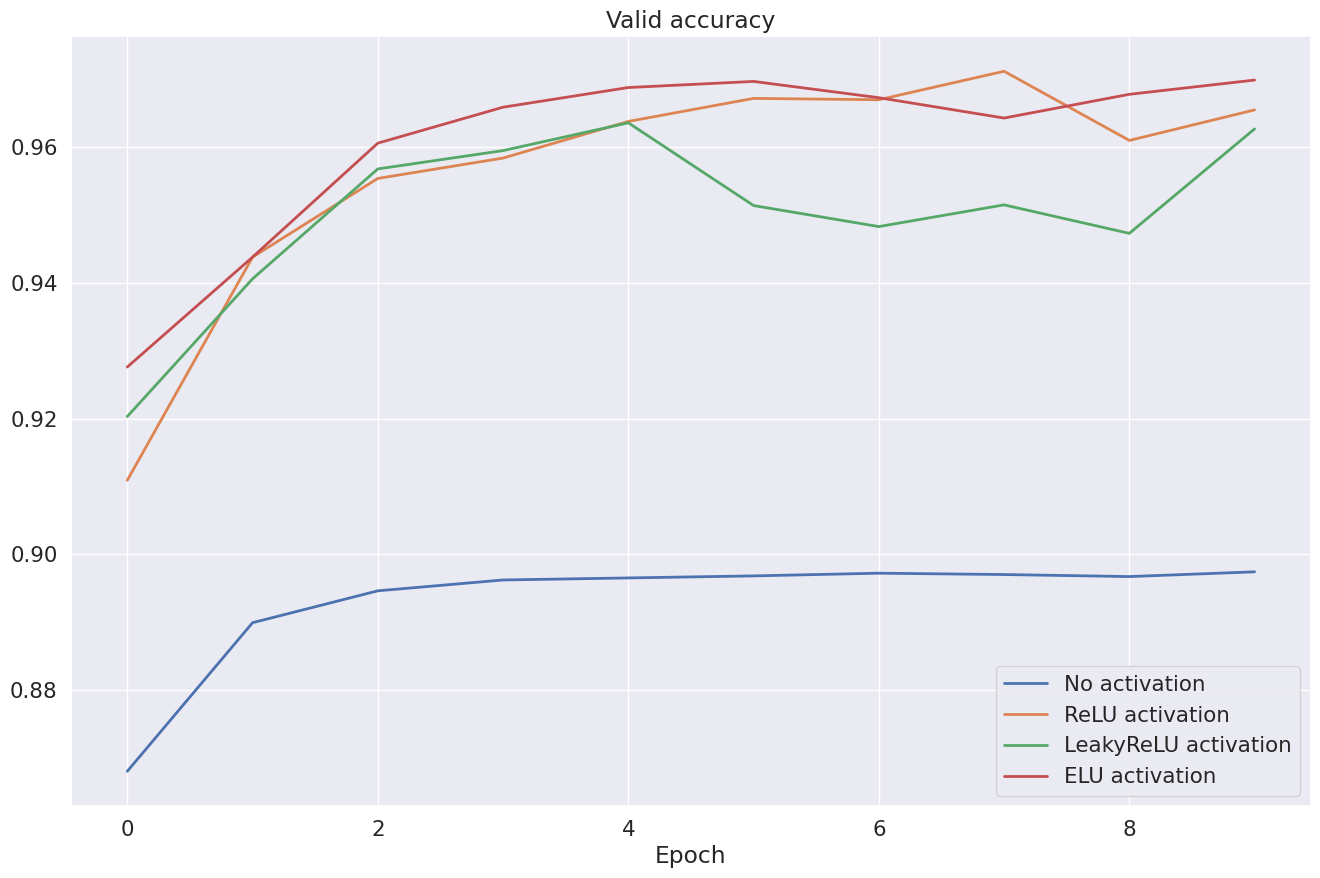

In [225]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['valid'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

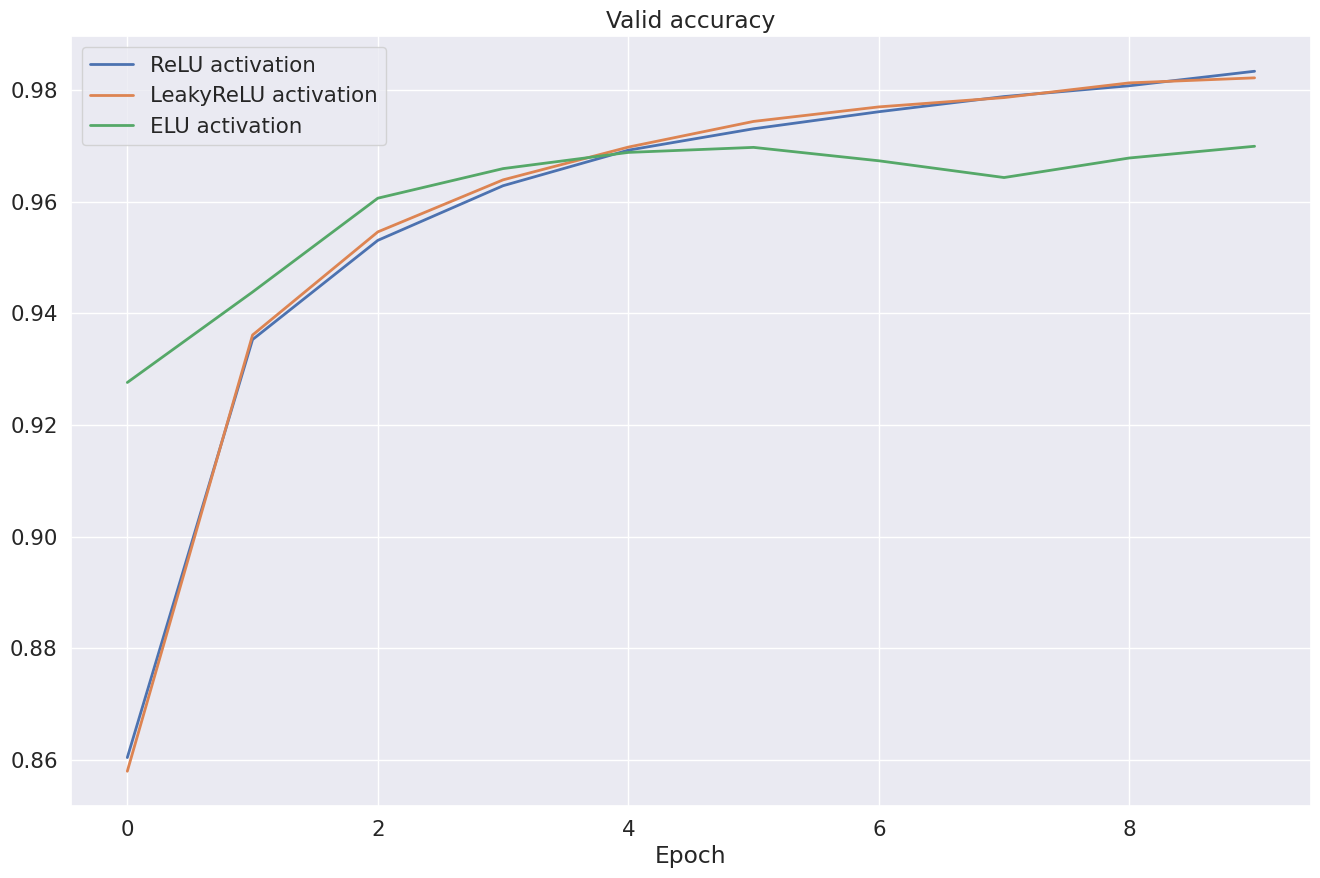

In [227]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['train'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['train'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** Небольшое преимущество у ReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [228]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2025-04-04 10:41:01--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   115KB/s    in 0.4s    

2025-04-04 10:41:02 (115 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



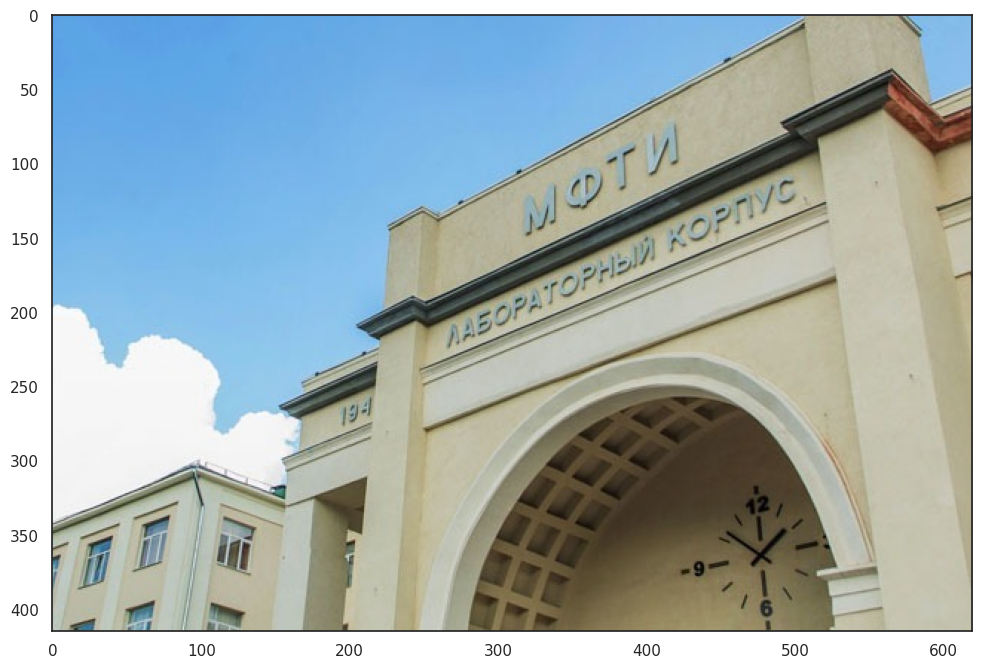

In [229]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [304]:
conv_1 = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]) # A
conv_2 = np.array([[0, 1, 0], [0, -2, 0], [0, 1, 0]]) # Б
conv_3 = np.array([[0, 0, 0], [1, -2, 1], [0, 0, 0]]) # В
conv_4 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]) # Г
conv_5 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Д
conv_6 = np.array([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]]) # E

In [305]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0) # добавляем измерение в начало
kernel = torch.tensor(conv_6).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  # базово - каждый выходной канал - это комбинация всех входных каналов
# для этого нам и понадобились ядра размерностью 3х3х3х3 - это матрица 3 на 3 в которой для каждого выходного канала
# хранятся ядра для обработки каждого из входных каналов

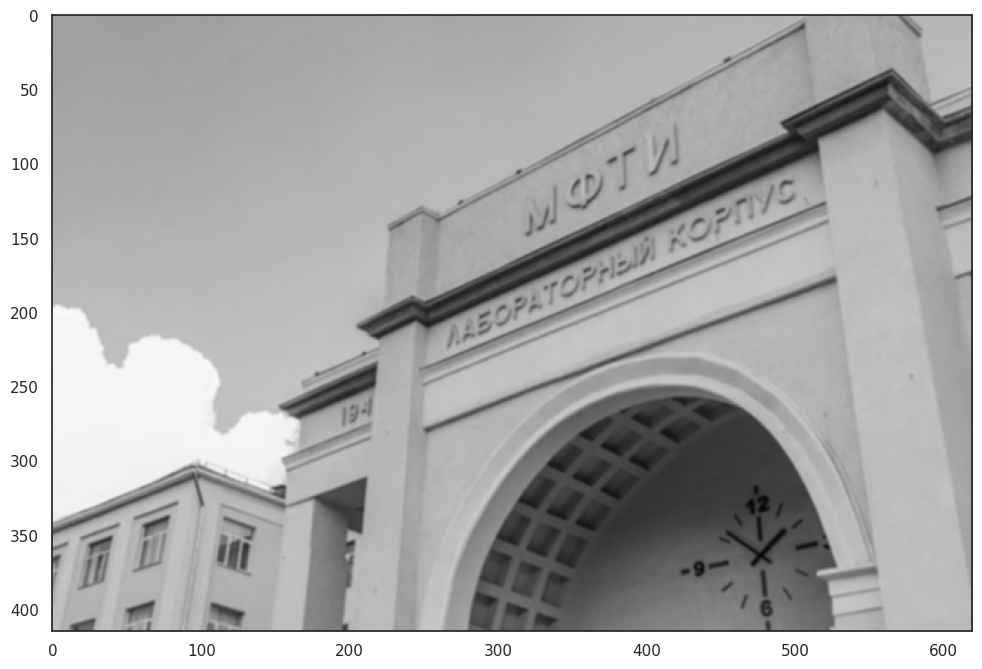

In [309]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() /256 /3

plt.imshow(result_np)
plt.show()

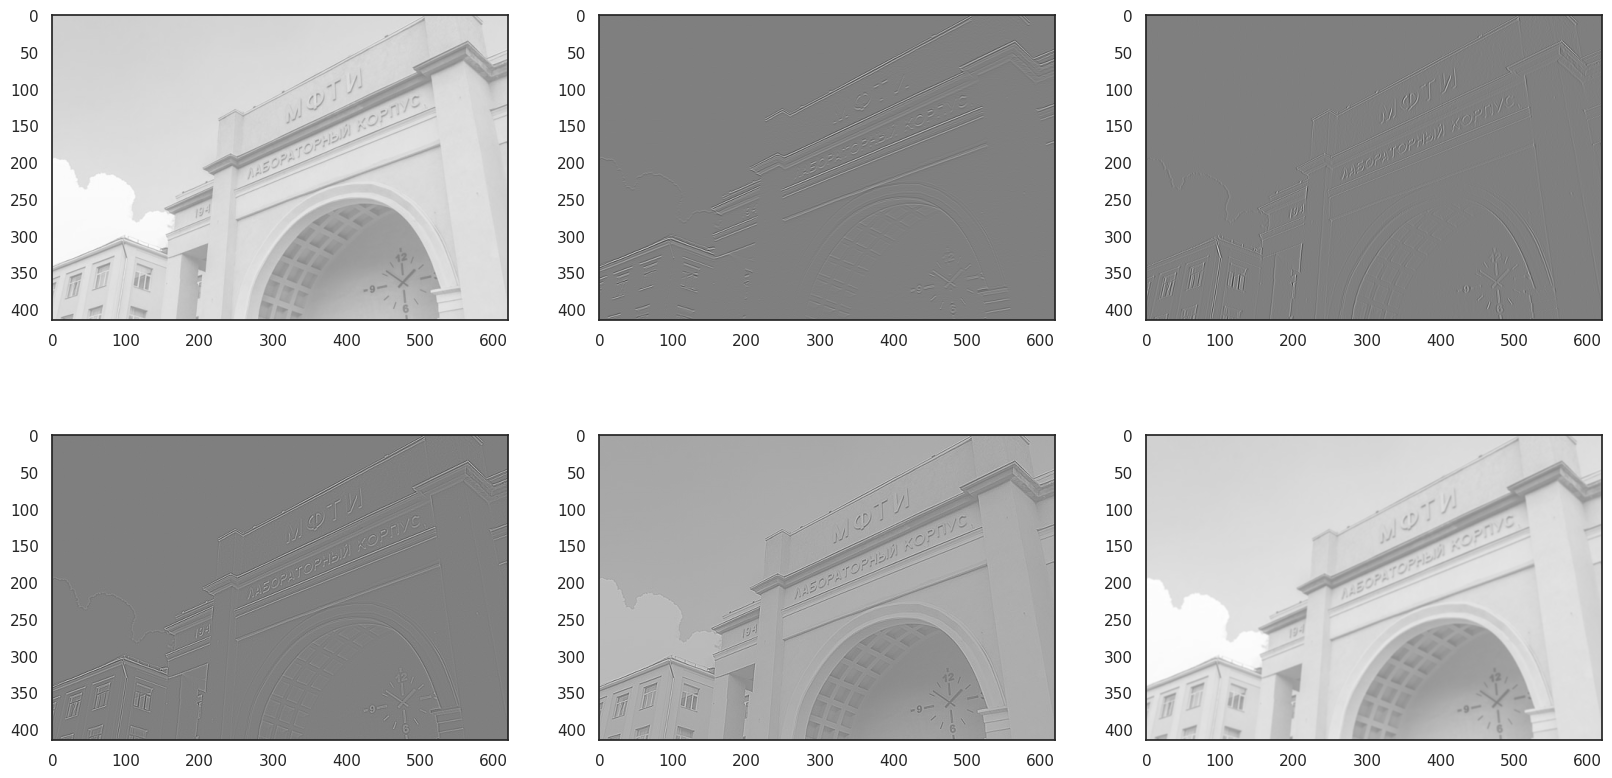

In [311]:
def apply_kernel(conv, img, ax):
  kernel = torch.tensor(conv).reshape(1, 1, 3, 3).type(torch.float32)
  kernel = kernel.repeat(3, 3, 1, 1)
  result = F.conv2d(img_t, kernel)[0]
  #plt.figure(figsize=(12, 8))
  result_np = result.permute(1, 2, 0).numpy() / result.max() / 2 + .5
  ax.imshow(result_np)
  #ax.show()


fig, axes = plt.subplots(2,3, figsize =(20, 10))
convs = [conv_1, conv_2, conv_3, conv_4, conv_5, conv_6]

for i, conv in enumerate(convs):
  apply_kernel(conv, img_t, axes[i//3][i%3])



**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

| Ядро | Эффект |
| -- |-- |
| А | 3 |
| Б | 5 |
| В | 4 |
| Г | 6 |
| Д | 2 |
| Е | 1 |



### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [320]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.act = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.pool1(x)
        x = self.act(self.conv2(x))
        x = self.pool2(x)
        x = self.flat(x)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.fc3(x)
        return x

In [321]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [322]:
accuracy = train_model(model, loaders)

--------epoch #1--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.34it/s]


Loader: train. Accuracy: 0.8692
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 36.38it/s]


Loader: valid. Accuracy: 0.9618
--------epoch #2--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 36.57it/s]


Loader: train. Accuracy: 0.9665166666666667
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 38.82it/s]


Loader: valid. Accuracy: 0.9741
--------epoch #3--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.64it/s]


Loader: train. Accuracy: 0.97685
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.74it/s]


Loader: valid. Accuracy: 0.9822
--------epoch #4--------
dataloader: train


100%|██████████| 469/469 [00:14<00:00, 33.35it/s]


Loader: train. Accuracy: 0.9824333333333334
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 44.11it/s]


Loader: valid. Accuracy: 0.9856
--------epoch #5--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.51it/s]


Loader: train. Accuracy: 0.9857666666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.87it/s]


Loader: valid. Accuracy: 0.9868
--------epoch #6--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.72it/s]


Loader: train. Accuracy: 0.9883166666666666
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 31.33it/s]


Loader: valid. Accuracy: 0.9861
--------epoch #7--------
dataloader: train


100%|██████████| 469/469 [00:14<00:00, 33.15it/s]


Loader: train. Accuracy: 0.9903666666666666
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.01it/s]


Loader: valid. Accuracy: 0.9855
--------epoch #8--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.11it/s]


Loader: train. Accuracy: 0.99175
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 43.10it/s]


Loader: valid. Accuracy: 0.9869
--------epoch #9--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.48it/s]


Loader: train. Accuracy: 0.9929666666666667
dataloader: valid


100%|██████████| 79/79 [00:01<00:00, 42.88it/s]


Loader: valid. Accuracy: 0.9871
--------epoch #10--------
dataloader: train


100%|██████████| 469/469 [00:12<00:00, 37.56it/s]


Loader: train. Accuracy: 0.994
dataloader: valid


100%|██████████| 79/79 [00:02<00:00, 36.51it/s]

Loader: valid. Accuracy: 0.9881


In [323]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

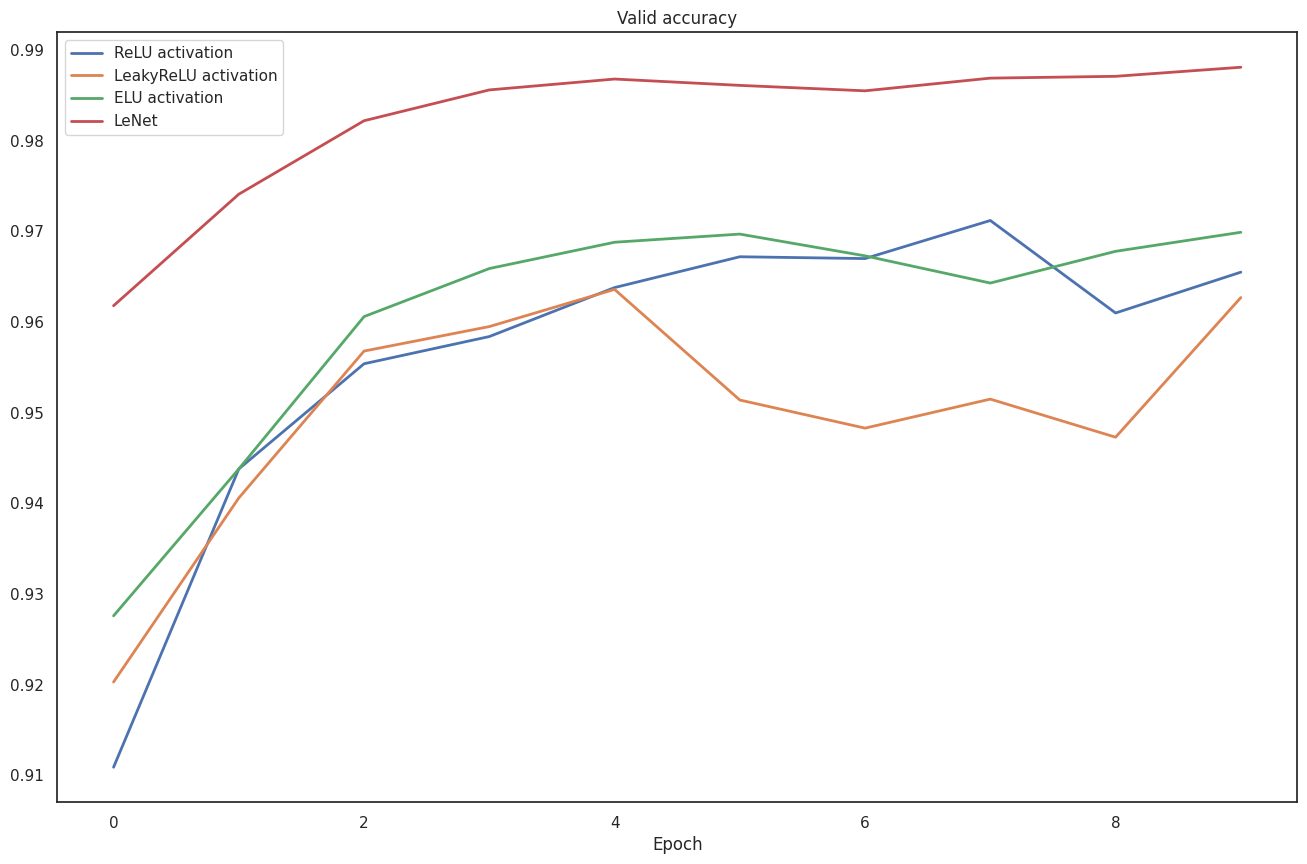

In [326]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**
0.99